<center><h1> Relax Challenge</h1></center>


The data is available as two attached CSV files: takehome_user_engagement.csv takehome_users.csv
- A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years.
- A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product

Defining an **adopted user** as a user who has logged into the product on three separate days in at least one seven-day period, *identify which factors predict future user adoption*.

We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better -- no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta

### Data Wrangling + EDA: Users

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])
users['creation_time'] = pd.to_datetime(users['creation_time'])

In [4]:
users.describe()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,0.432742,0.356432,124.056723,3383.761968
min,1.00000,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.000000,1.000000,416.000000,11999.000000


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [6]:
# Isolate the columns with missing values
users.isnull().sum()[users.isnull().sum() > 0]

last_session_creation_time    3177
invited_by_user_id            5583
dtype: int64

- We need to remove columns that won't be used in our model
   - Remove:  name, email, creation_time, last_session_creation_time
- We need to impute, transform, or remove the features with missing values.
    - We can turn invited_by_user_id into whether or not they were by invited by another user instead.
    - Last session creation time can be dropped along with other columns that won't be used on our model.
- We need to make dummy variables for creation_source

In [7]:
users['Days Since Signed Up'] = users['creation_time'].apply(lambda x:(users['creation_time'].max() - x).days)

In [8]:
for index, row in users['invited_by_user_id'].iteritems():
    if row > 0:
        users.loc[index,'invited_by_user_id'] = True
    else:
        users.loc[index,'invited_by_user_id'] = False
users = users.rename(columns={'invited_by_user_id': 'invited_by_user'})

In [9]:
users = users.drop(['name', 'email', 'last_session_creation_time', 'creation_time'], axis=1)

In [10]:
users = pd.get_dummies(users, columns = ['creation_source'], drop_first=False)

In [11]:
users.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user,Days Since Signed Up,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1,0,11,True,38,1,0,0,0,0
1,2,0,0,1,True,196,0,1,0,0,0
2,3,0,0,94,True,437,0,1,0,0,0
3,4,0,0,1,True,374,1,0,0,0,0
4,5,0,0,193,True,498,1,0,0,0,0


### Data Wrangling + EDA: Engagement

In [12]:
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [13]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [14]:
# convert timestamp to datetime object
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

# calculate each activity's adoption window as time + 7 days
engagement['seven_day_period'] = engagement['time_stamp'] + timedelta(days=7)

# count the visits by the same user with a timestamp before the date plus 7 days
activity_in_seven_days = []
for i in range(len(engagement['time_stamp'])):
    activity_in_seven_days.append(((engagement['time_stamp'] <= engagement['seven_day_period'][i]) & 
                          (engagement['user_id'] == engagement['user_id'][i])).sum())

# convert list to series and add to dataframe
engagement['activity_in_seven_days'] = pd.Series(activity_in_seven_days)

# mark adoption events for weeks that have 3+ activities by the user
engagement['Adopted User'] = engagement['activity_in_seven_days'] >= 3

In [15]:
engagement.head()

,time_stamp,user_id,visited,seven_day_period,activity_in_seven_days,Adopted User
0,2014-04-22 03:53:30,1,1,2014-04-29 03:53:30,1,False
1,2013-11-15 03:45:04,2,1,2013-11-22 03:45:04,1,False
2,2013-11-29 03:45:04,2,1,2013-12-06 03:45:04,2,False
3,2013-12-09 03:45:04,2,1,2013-12-16 03:45:04,3,True
4,2013-12-25 03:45:04,2,1,2014-01-01 03:45:04,5,True


In [16]:
user_engagement = engagement.groupby('user_id').sum().reset_index()
user_engagement.head()

,user_id,visited,activity_in_seven_days,Adopted User
0,1,1,1,0.0
1,2,14,114,12.0
2,3,1,1,0.0
3,4,1,1,0.0
4,5,1,1,0.0


In [17]:
# Group by user ID, so we can merge the dataframes
user_engagement = engagement.groupby('user_id').sum().reset_index()
#Changing Adopted Users to binary column 
user_engagement['Adopted User'] = user_engagement['Adopted User'] >= 1
# Dropping unneeded columns
user_engagement = user_engagement.drop(['visited','activity_in_seven_days'], axis=1)

# Merge the dataframes
df = pd.merge(users, user_engagement, how='left', left_on='object_id', right_on='user_id').drop(['user_id','object_id'], axis=1).fillna(0)

df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user,Days Since Signed Up,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,Adopted User
0,1,0,11,True,38,1,0,0,0,0,False
1,0,0,1,True,196,0,1,0,0,0,True
2,0,0,94,True,437,0,1,0,0,0,False
3,0,0,1,True,374,1,0,0,0,0,False
4,0,0,193,True,498,1,0,0,0,0,False


In [18]:
df[['invited_by_user','Adopted User']] = df[['invited_by_user','Adopted User']].astype(int)
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user,Days Since Signed Up,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,Adopted User
0,1,0,11,1,38,1,0,0,0,0,0
1,0,0,1,1,196,0,1,0,0,0,1
2,0,0,94,1,437,0,1,0,0,0,0
3,0,0,1,1,374,1,0,0,0,0,0
4,0,0,193,1,498,1,0,0,0,0,0


# Modeling

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [20]:
X = df.drop('Adopted User', axis=1)
y = df['Adopted User']

# Splitting the dataset into the Training set and Test set#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Logistic Regression

In [21]:
log_reg = LogisticRegression(class_weight="balanced", random_state=1)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

print("Score:", log_reg.score(X_test, y_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

Score: 0.541944444444
Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.52      0.65      2886
          1       0.24      0.61      0.35       714

avg / total       0.73      0.54      0.59      3600



In [22]:
logreg = LogisticRegression(class_weight="balanced", random_state=1)
param_grid = {'C':[0.01,0.1,1,10,100]}
logreg_cv = GridSearchCV(logreg,param_grid,cv=5)

logreg_cv.fit(X_train,y_train)
y_pred_log_regcv =logreg_cv.predict(X_test)
score=logreg_cv.score(X_train,y_train)
print("Score:", logreg_cv.score(X_test, y_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_log_regcv))

Score: 0.541944444444
Classification Report:
             precision    recall  f1-score   support

          0       0.84      0.52      0.65      2886
          1       0.24      0.61      0.35       714

avg / total       0.73      0.54      0.59      3600



In [23]:
pd.DataFrame(index=X.columns, data=log_reg.coef_[0],
                       columns=['Coef']).sort_values(by='Coef', ascending=False)

,Coef
org_id,0.207613
Days Since Signed Up,0.161147
creation_source_SIGNUP_GOOGLE_AUTH,0.103969
creation_source_GUEST_INVITE,0.074876
creation_source_SIGNUP,0.050817
invited_by_user,0.047705
enabled_for_marketing_drip,0.047213
creation_source_ORG_INVITE,-0.009765
opted_in_to_mailing_list,-0.020518
creation_source_PERSONAL_PROJECTS,-0.198528


## Random Forest

In [24]:
rfc = RandomForestClassifier(class_weight="balanced", random_state=1)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

print("Score:", rfc.score(X_test, y_test))
print("Classification Report:")
print(classification_report(y_test, y_pred_rfc))

Score: 0.764722222222
Classification Report:
             precision    recall  f1-score   support

          0       0.81      0.93      0.86      2886
          1       0.28      0.12      0.16       714

avg / total       0.70      0.76      0.72      3600



In [45]:
parameters = {'n_estimators': np.arange(5,50,5)}
rfc = RandomForestClassifier(class_weight="balanced", random_state=1, n_jobs=-1)
rfc_gs = GridSearchCV(rfc, parameters)
rfc_gs.fit(X_train, y_train)

results_rfc_gs = pd.DataFrame(rfc_gs.cv_results_)
results_rfc_gs.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,0.130551,0.106549,0.784286,0.969524,10,{'n_estimators': 10},1,0.786148,0.971602,0.782500,0.967500,0.784209,0.969470,0.007628,0.003007,0.001490,0.001675
3,0.135721,0.110355,0.782262,0.987798,20,{'n_estimators': 20},2,0.784363,0.988569,0.780000,0.988393,0.782422,0.986431,0.007604,0.000310,0.001785,0.000969
5,0.144058,0.104494,0.781429,0.993988,30,{'n_estimators': 30},3,0.782935,0.994106,0.782143,0.995000,0.779207,0.992858,0.007057,0.001091,0.001603,0.000878
7,0.152063,0.105581,0.781071,0.995893,40,{'n_estimators': 40},4,0.783292,0.995892,0.780714,0.996071,0.779207,0.995715,0.010962,0.000255,0.001687,0.000145
8,0.149510,0.104076,0.778095,0.997559,45,{'n_estimators': 45},5,0.782221,0.997142,0.775357,0.997857,0.776706,0.997679,0.004600,0.001333,0.002969,0.000304
4,0.136037,0.105375,0.776786,0.993750,25,{'n_estimators': 25},6,0.777936,0.993213,0.775714,0.994821,0.776706,0.993215,0.007383,0.000470,0.000909,0.000758
6,0.136124,0.104162,0.776786,0.997143,35,{'n_estimators': 35},6,0.778650,0.996607,0.776786,0.997679,0.774920,0.997143,0.005329,0.001096,0.001523,0.000438
2,0.131794,0.108557,0.773452,0.987619,15,{'n_estimators': 15},8,0.777936,0.988569,0.769286,0.987679,0.773133,0.986610,0.005975,0.001991,0.003539,0.000801
0,0.115981,0.108709,0.758452,0.961310,5,{'n_estimators': 5},9,0.762585,0.962493,0.756786,0.959643,0.755984,0.961793,0.005158,0.000222,0.002941,0.001213


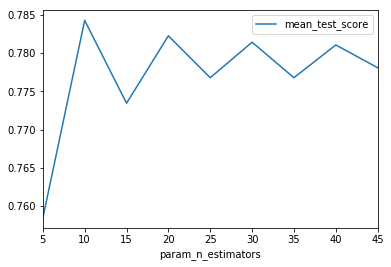

In [46]:
results_rfc_gs.plot('param_n_estimators','mean_test_score')

In [47]:
parameters = {'max_features':['sqrt',.1,.3,.5,.7,1.0]}

rfc = RandomForestClassifier(class_weight="balanced", random_state=1, n_estimators= 10, n_jobs=-1)
rfc_gs = GridSearchCV(rfc, parameters, n_jobs=-1)
rfc_gs.fit(X_train, y_train)

results_rfc_gs = pd.DataFrame(rfc_gs.cv_results_)
results_rfc_gs.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_features,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
4,0.210974,0.108153,0.785952,0.971071,0.7,{'max_features': 0.7},1,0.785077,0.971781,0.785000,0.969643,0.787781,0.971791,0.045630,0.002223,0.001293,0.001010
0,0.116034,0.104852,0.784286,0.969524,sqrt,{'max_features': 'sqrt'},2,0.786148,0.971602,0.782500,0.967500,0.784209,0.969470,0.000463,0.000221,0.001490,0.001675
2,0.135960,0.109931,0.784286,0.969524,0.3,{'max_features': 0.3},2,0.786148,0.971602,0.782500,0.967500,0.784209,0.969470,0.015893,0.006786,0.001490,0.001675
5,0.124388,0.104984,0.782857,0.970893,1,{'max_features': 1.0},4,0.786148,0.973388,0.785000,0.967857,0.777421,0.971434,0.004717,0.000798,0.003872,0.002290
1,0.116199,0.104408,0.781190,0.968929,0.1,{'max_features': 0.1},5,0.782935,0.973031,0.779643,0.966250,0.780993,0.967506,0.000685,0.000485,0.001351,0.002946
3,0.144612,0.110515,0.780476,0.970476,0.5,{'max_features': 0.5},6,0.781150,0.971423,0.777500,0.968750,0.782780,0.971255,0.009907,0.007053,0.002207,0.001223


In [48]:
rfc = RandomForestClassifier(class_weight="balanced", n_estimators=10, max_features=.7,random_state=1)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)

rfc_score = rfc.score(X_test, y_test)
print("Score:", rfc_score)
print("Classification Report:")
print(classification_report(y_test, y_pred_rfc))

Score: 0.775555555556
Classification Report:
             precision    recall  f1-score   support

          0       0.81      0.94      0.87      2886
          1       0.30      0.10      0.15       714

avg / total       0.71      0.78      0.73      3600



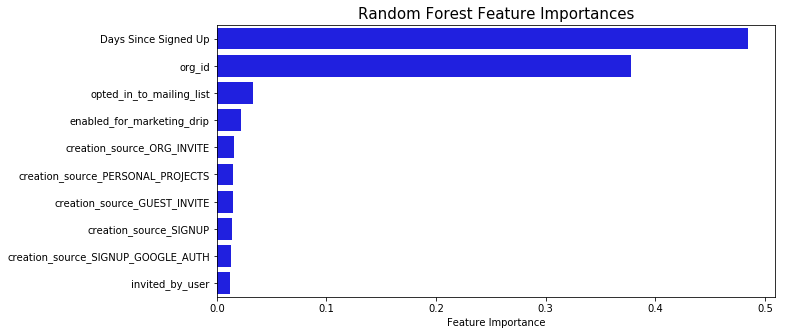

In [49]:
# Ordering columns by feature importance
rfc_fi = pd.DataFrame(index=X.columns, data=rfc.feature_importances_,
                       columns=['Feature Importance']).sort_values(by='Feature Importance', ascending=False)

fig = plt.figure(figsize=(10,5))
fig = sns.barplot(y=rfc_fi.index, x=rfc_fi['Feature Importance'],color="blue")
_ = plt.title('Random Forest Feature Importances', size=15)

## Most Important Features

The most important features for predicting how old the account is, the organization id, whether or not they opted in to the mailing list. 